# KVLCC2 model tests

# Purpose
Analyze the model tests and build roll decay mathematical models.

# Methodology
Look at the results from the KVLCC2 ship.
* Load model test data
* Determine damping by fitting an apropriate model.
* Save these models to pkl files.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators.direct_estimator_cubic import EstimatorCubic,EstimatorQuadraticB
from sklearn.base import clone
from copy import deepcopy
import joblib
from reports import mdl_results

In [3]:
df_rolldecays = mdl_results.df_rolldecays

In [4]:
df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,rho,g,paper_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,1
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,2
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,NaN,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,NaN,NaN,NaN,20.8,11.2672,18.6,5.73,NaN,20.8,20.8,NaN,23.2,80.0,NaN,NaN,312653.0,0.99538,NaN,68.0,320.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.81,3


In [5]:
df_rolldecays[['date','ship_speed']]

,date,ship_speed
id,,
21337,2018-04-03,0.0
21338,2018-04-03,0.0
21340,2018-04-04,15.5


<a id='rolldecay'></a>

In [6]:
def load_run(id, save_dir='../../data/processed/roll decay KVLCC2'):
    save_file_name = 'model_test_%s.csv' % id
    save_path = os.path.join(save_dir, save_file_name)
    df = pd.read_csv(save_path, index_col=0)
    
    save_path_units = os.path.join(save_dir, 'model_test_units.csv')
    units = pd.read_csv(save_path_units,index_col=0).transpose().iloc[0]
    return df,units

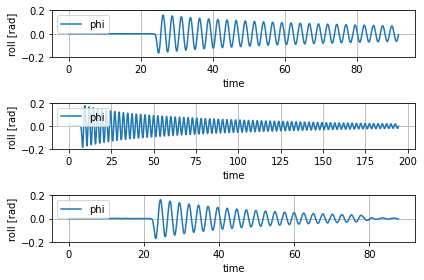

In [7]:
fig,axes=plt.subplots(nrows=len(df_rolldecays))

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    df, units = load_run(id=id)    
    df.plot(y='phi', ax=ax)
    ax.set_ylabel(f"roll [{units['phi']}]")
    ax.grid(True)
    ax.set_ylim([-0.2,0.2])
    
plt.tight_layout()

## Analyze the damping

In [8]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.999)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(3.5), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

In [9]:
estimator_cubic = EstimatorCubic(fit_method='derivation')

In [10]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
#    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic)
]

pipline_cubic = Pipeline(steps=steps)

### Cubic

In [13]:
models_cubic_int = OrderedDict()
scores = pd.DataFrame()

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    df, units = load_run(id=id)
    
    estimator_cubic_der = EstimatorCubic(fit_method='derivation', maxfev=100000)
    steps = [
        ('filter',lowpass_filter),
        ('cutter', cutter), 
        ('estimator', estimator_cubic_der)
    ]
    pipline_cubic_der = Pipeline(steps=steps)
    pipline_cubic_der.fit(X=df[['phi']])
    
    estimator_cubic_int = EstimatorCubic(fit_method='integration', maxfev=100000, 
                                         p0=estimator_cubic_der.parameters)
    steps = [
        ('filter',lowpass_filter),
        ('cutter', cutter), 
        ('estimator', estimator_cubic_int)
    ]
    pipline_cubic_int = Pipeline(steps=steps)
    pipline_cubic_int.fit(X=df[['phi']])
    
    scale_factor = row.scale_factor
    Disp = row.Volume/(scale_factor**3)
    meta_data = {
    'Volume' : Disp,
    'GM': row.gm/scale_factor,
    'rho':1000,
    'g':9.81,
    }
    result = estimator_cubic_int.result_for_database(meta_data=meta_data)
    
    scores.loc['models_cubic_int',id] = pipline_cubic_int.score(X=df[['phi']])
    
    models_cubic_int[id]=deepcopy(pipline_cubic_int)

<a id='cubic_model'></a>

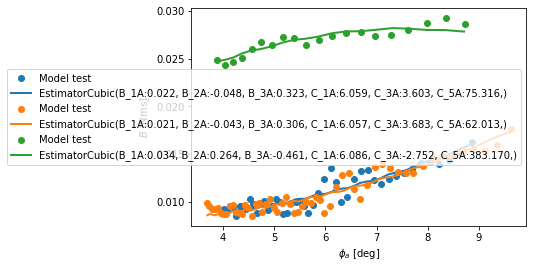

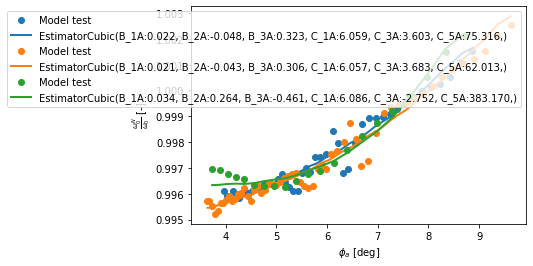

In [14]:
fig,ax=plt.subplots()

colors = ['r','g','b']
markers = ['o','*','+']

for id, model in models_cubic_int.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax)
    
fig,ax=plt.subplots()
for id, model in models_cubic_int.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=True)

In [15]:
scores

,21337,21338,21340
models_cubic_int,0.99998,0.999968,0.999973


## Save models

In [16]:
for name, model in models_cubic_int.items():
    joblib.dump(model, '../../models/KVLCC2_%i.pkl' % name)